<a href="https://colab.research.google.com/github/Astromax/Reuters_Text_Classification/blob/main/Reuters_Text_Classification_sklearn_PyTorch.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

The objective here is to do some preliminary text classification and analysis of the documents in the Reuters-21578 dataset, labeling articles according to whether or not they are in categories like "earn", "cocoa", and "zinc".

In [ ]:
#NEEDED FOR TRAINING
#NEEDED FOR INFERENCE
#Because the data is in a Google Drive folder, we start by mounting the drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
#Check that we can see the target directory...check
!ls '/content/drive/My Drive/reuters21578'

In [ ]:
#NEEDED FOR TRAINING
#NEEDED FOR INFERENCE
#Main imports...
import ast
from bs4 import BeautifulSoup
import copy
import csv
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import random
import re
import seaborn as sns

from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, accuracy_score, f1_score, precision_score, recall_score
from sklearn.metrics import multilabel_confusion_matrix as MLCM
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import make_pipeline
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier

import spacy

import torch 
import torch.nn as nn
import torch.nn.functional as F 
import torch.optim as optim
from torchtext.legacy import data
from torchtext.legacy import datasets

import xml.sax.saxutils as saxutils

In [ ]:
#NEEDED FOR TRAINING
#NEEDED FOR INFERENCE
#Set random seeds and globals
random.seed(37)
np.random.seed(37)
MAIN_CATEGORIES = []                            #Categories available in the full dataset
WORD_THRESHOLD = 10                             #Minimum number of words in body of text for article to be kept

BATCH_SIZE = 64                                 #Batch size for PyTorch models in Part 2

nlp = spacy.load('en')                          #Tokenizer for inference at the end

In [ ]:
#Declare names of most outputs from Part 0 & Part 1,
#names of individual sklearn models vs accuracy, F1, and article count named in respective cells
charlengthstats = 'fullset_article_character_length_stats'
wordcountstats = 'fullset_article_wordcount_stats'
redarticlecount = 'reduced_article_counts'
corrheatmap = 'trainset_correlation_heatmap'
earncorr = 'earn_cross_correlations'
sklearnmetrics = 'category_metrics_with_sklearners'
refsklearnmetrics = 'category_metrics_with_sklearners_refined'

In [ ]:
#NEEDED FOR TRAINING
#NEEDED FOR INFERENCE
main_dir = '/content/drive/MyDrive/Interos_Take_Home_Challenge'
modelfilepath = f'{main_dir}/trained_model.pt'  #Path to save the trained model in Part 2
os.chdir(main_dir)
reuter_dir = '/content/drive/My Drive/reuters21578/'
with open(reuter_dir + 'all-topics-strings.lc.txt', 'r') as f:
    for cat in f.readlines():
        MAIN_CATEGORIES.append(cat.strip().lower())

print('Number of categories: ', len(MAIN_CATEGORIES))
print('First category: ', MAIN_CATEGORIES[0])
print('Last category: ', MAIN_CATEGORIES[-1])

Number of categories:  135
First category:  acq
Last category:  zinc


##Acknowledgements
Several online resources were consulted in the construction of this notebook. \\
I had not previously worked with SGML data, so the helper functions from this github https://github.com/amir-rahnama/topic-classification-reuters-21578/blob/master/data/reader.py 
were immensely helpful.  The relevant functions are: unescape, strip_tags, category_to_multihot, and read_reuters_SGML. \\
TorchText is a module I had not previously used, consequently the Jannenev github https://github.com/jannenev/reuters proved immeasurably helpful (though it turns out TorchText has updated and the most important functions of it for this project are not in TorchText legacy). Jannenev also worked on a version of this same Reuters data and had characterized many different models, and found much to my surprise that CNN models actually learned much more quickly on this data than RNN or LSTM models; this is surprising because typically one expects RNNs/LSTMs to be more effective with sequential data.  As such, I bored Jannenev's high-performing CNN2D model, and similarly found it to learn *very* effectively on this data. \\ 
I had a weirdly difficult time figuring out how to allow someone to input new articles, this page was a great assist for that: https://www.analyticsvidhya.com/blog/2020/01/first-text-classification-in-pytorch/ 

Accessing the data was made immensely easier thanks to the code provided by: https://github.com/amir-rahnama/topic-classification-reuters-21578/blob/master/data/reader.py
The helper functions unescape, strip_tags, category_to_multihot, and read_reuters_SGML were all either taken whole-cloth or heavily inspired by Amir's Github.  

In [ ]:
#NEEDED FOR TRAINING?
#NEEDED FOR INFERENCE
#Set of helper functions
def unescape(text):
    """Unescape charactes."""
    return saxutils.unescape(text)


def strip_tags(text):
    """String tags for a better vocabulary."""
    return re.sub('<[^<]+?>', '', text).strip()


def category_to_multihot(main_categories: list, doc_categories: list) -> np.array:
    """Convert category list to multihot vector"""
    vector = np.array([(1.0 if cat in doc_categories else 0.0) for cat in main_categories]).astype(np.float32)
    return vector


def multihot_to_category(main_categories: list, multihot: np.array) -> list:
    """Convert a multihot vector back into a list of categories"""
    doc_categories = [cat for idx,cat in enumerate(main_categories) if multihot[idx] == 1]
    return doc_categories

In [ ]:
def read_reuters_SGML(path=reuter_dir, threshold: int=WORD_THRESHOLD):
    X = {}
    y = {}

    for file in os.listdir(path):
        if file.endswith('.sgm'):
            f = open(path + file, 'r', encoding="ISO-8859-1")
            data = f.read()

            soup = BeautifulSoup(data, 'html.parser')
            posts = soup.findAll('reuters')

            print('Number of posts in file %s: %i' % (file, len(posts)))

            for post in posts:
                post_id = post['newid']

                body = str(post('body'))[7:-9] #Strip off <body> from front & </body> from the back

                if body is None or body == 'None':
                    print('body is None')
                    return 
                                
                words = body.split(' ')
                
                #Make sure article has enough words to be useful
                if len(words) < threshold:
                    continue

                post_categories = []
                topics = post.topics.contents

                for topic in topics:
                    post_categories.append(strip_tags(str(topic)))

                post_categories = list(set(post_categories)) #Eliminate duplicates
                #Don't include documents with no categories
                if len(post_categories) < 1:
                    continue

                X[post_id] = body
                y[post_id] = post_categories

    print('Number of samples: ', len(X))
    return (X, y)

In [ ]:
#First: get the training data & the test data
X, y = read_reuters_SGML()

Number of posts in file reut2-000.sgm: 1000
Number of posts in file reut2-001.sgm: 1000
Number of posts in file reut2-002.sgm: 1000
Number of posts in file reut2-004.sgm: 1000
Number of posts in file reut2-003.sgm: 1000
Number of posts in file reut2-005.sgm: 1000
Number of posts in file reut2-006.sgm: 1000
Number of posts in file reut2-007.sgm: 1000
Number of posts in file reut2-009.sgm: 1000
Number of posts in file reut2-008.sgm: 1000
Number of posts in file reut2-010.sgm: 1000
Number of posts in file reut2-011.sgm: 1000
Number of posts in file reut2-012.sgm: 1000
Number of posts in file reut2-013.sgm: 1000
Number of posts in file reut2-015.sgm: 1000
Number of posts in file reut2-014.sgm: 1000
Number of posts in file reut2-016.sgm: 1000
Number of posts in file reut2-017.sgm: 1000
Number of posts in file reut2-018.sgm: 1000
Number of posts in file reut2-019.sgm: 1000
Number of posts in file reut2-020.sgm: 1000
Number of samples:  10083


Number of short articles:  0


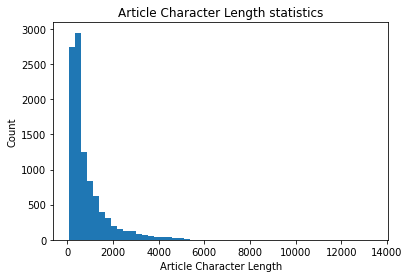

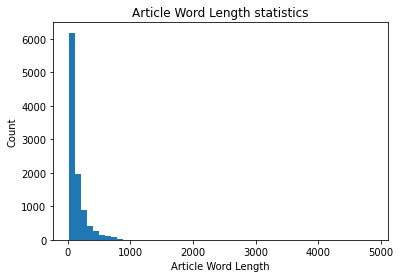

In [ ]:
#Let's get some simple stats about the length of the articles...in terms of characters and words
char_lengths = [len(v) for k,v in X.items()]
word_lengths = [len(v.split(' ')) for k,v in X.items()]

print('Number of short articles: ', len([t for t in word_lengths if t < WORD_THRESHOLD])) #Just double-checking...

plt.hist(char_lengths, density=False, bins=50)
plt.title('Article Character Length statistics')
plt.xlabel('Article Character Length')
plt.ylabel('Count')
plt.savefig(f'{main_dir}/{charlengthstats}.png')
plt.show()

plt.hist(word_lengths, density=False, bins=50)
plt.title('Article Word Length statistics')
plt.xlabel('Article Word Length')
plt.ylabel('Count')
plt.savefig(f'{main_dir}/{wordcountstats}.png')
plt.show()

In [ ]:
#Now split into train & test sets, using the ids once again.  
ids = list(X.keys())
test_split = 0.3
train_length = int(len(ids) * (1 - test_split))
train_ids = random.sample(ids, train_length)
test_ids = [i for i in ids if i not in train_ids]

print('Number of train samples: ', len(train_ids))
print('Number of test samples: ', len(test_ids))

X_train = {k:v for k,v in X.items() if k in train_ids}
X_test = {k:v for k,v in X.items() if k in test_ids}
y_train = {k:v for k,v in y.items() if k in train_ids}
y_test = {k:v for k,v in y.items() if k in test_ids}

Number of train samples:  7058
Number of test samples:  3025


## Part 0: Simple Exploratory Data Analysis
Let's get a simple tally of how many articles there are of each category, then do a bit of a dive into the "earn" category specifically.

In [ ]:
#We're only going to do these tallies of the training set to avoid indirectly contaminating knowledge about the test set
category_article_counts = {k:0 for k in MAIN_CATEGORIES}

for cats in list(y_train.values()):
    for c in cats:
        category_article_counts[c] += 1

#print('Category article counts: ')
#for k,v in category_article_counts.items():
#    print('Category: %s, Article Count: %i' % (k,v))

Alright, we clearly have a *huge* class imbalance here, some categories don't appear at all in the training set, which means the models will have a hell of a time figuring out how to classify them.  Let's filter out all categories with zero articles in the training set.  We will NOT get any stats for the test set at this time to avoid contamination.

In [ ]:
rare_categories = [k for k,v in category_article_counts.items() if v == 0]
print('Number of rare categories: ', len(rare_categories))

#Let's eliminate these from the MAIN_CATEGORIES, we don't need to modify y_train/y_test for sklearn because the categories
#are tested individually, therefore the y_train values get binarized
REMAIN_CATEGORIES = sorted(list(set(MAIN_CATEGORIES) - set(rare_categories)))
print('Remaining number of Categories: ', len(REMAIN_CATEGORIES))

Number of rare categories:  20
Remaining number of Categories:  115


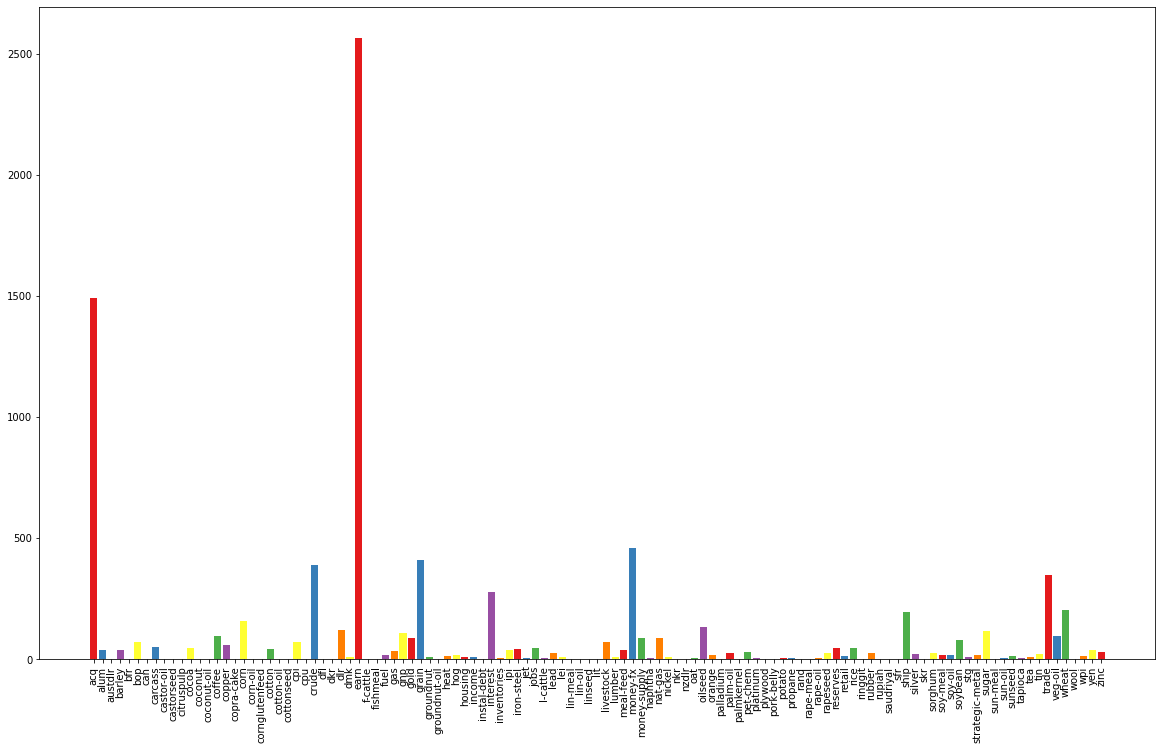

In [ ]:
reduced_article_counts = {k:v for k,v in category_article_counts.items() if v > 0}
ind = np.arange(len(reduced_article_counts))
palette = sns.color_palette('Set1', 6)
plt.figure(figsize=(20,12))
plt.bar(ind, list(reduced_article_counts.values()), color=palette)
plt.xticks(ind, list(reduced_article_counts.keys()))
plt.xticks(rotation=90, fontsize=10)
plt.savefig(f'{main_dir}/{redarticlecount}.png')
plt.show()

Let's see how different categories correlate with each other. Specifically, given that an article is in category *x*, what is the probability that it is also in category *y*, P(y|x).  We're going to calculate this the simple way: P(x & y)/P(x). 

In [ ]:
#Only use the training set for this, we might produce a similar one for the test set later
training_cats = y_train.values()

correlation = [[0] * len(REMAIN_CATEGORIES) for _ in range(len(REMAIN_CATEGORIES))]

for idx, cat in enumerate(REMAIN_CATEGORIES):
    row = correlation[idx]
    catset = [lst for lst in training_cats if cat in lst]
    ncat = len(catset) 
    for jdx, jcat in enumerate(REMAIN_CATEGORIES):
        jcatset = [jst for jst in catset if jcat in jst]
        row[jdx] = len(jcatset)/ncat 

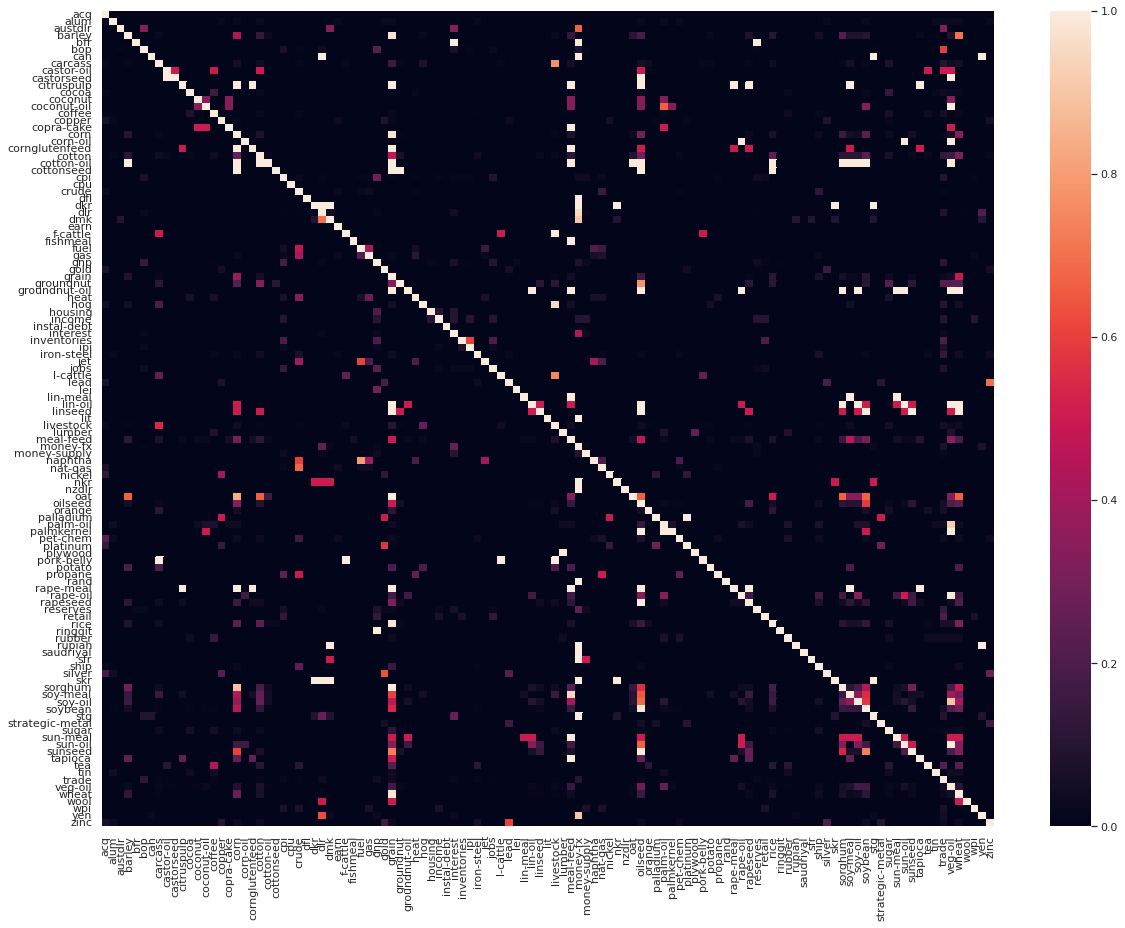

In [ ]:
sns.set(rc = {'figure.figsize': (20, 15)})
fig = sns.heatmap(correlation, xticklabels=REMAIN_CATEGORIES, yticklabels=REMAIN_CATEGORIES)
fig.figure.savefig(f'{main_dir}/{corrheatmap}.png')

Earn index:  30


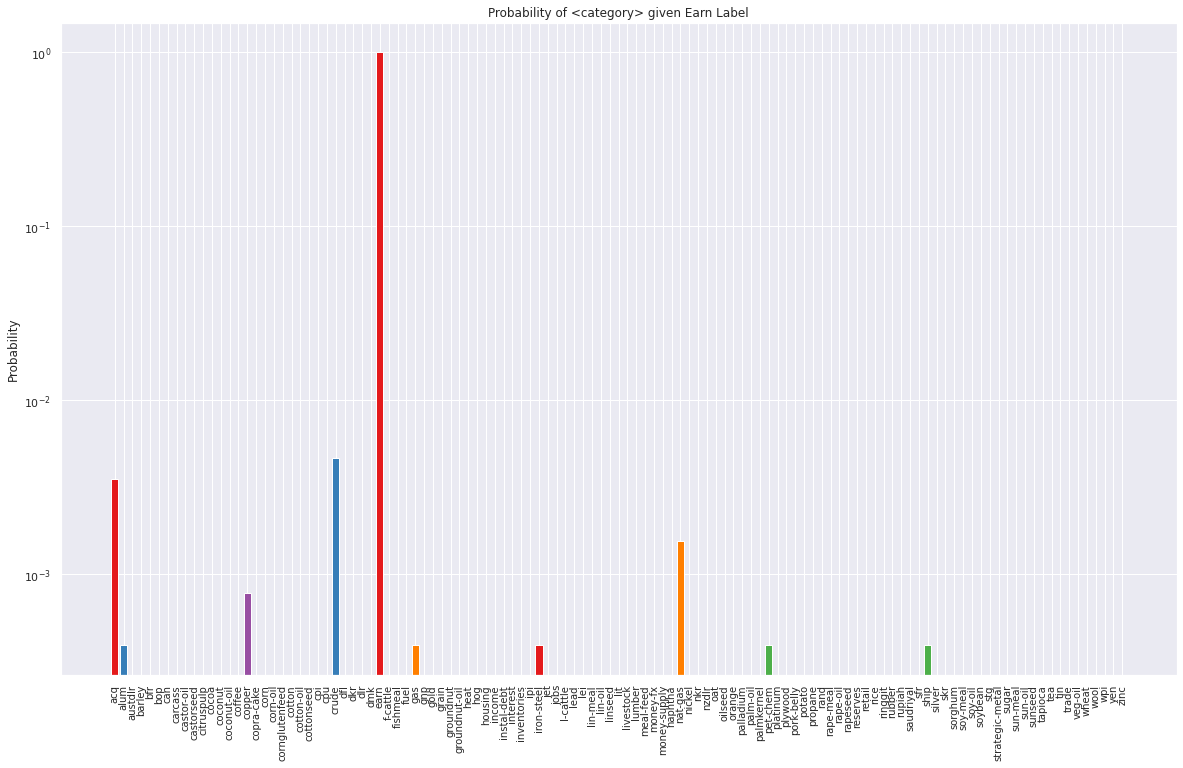

In [ ]:
earn_idx = REMAIN_CATEGORIES.index('earn')
print('Earn index: ', earn_idx)
earn_corr = correlation[earn_idx]

plt.figure(figsize=(20,12))
plt.bar(ind, earn_corr, color=palette)
plt.xticks(ind, REMAIN_CATEGORIES)
plt.xticks(rotation=90, fontsize=10)
plt.title('Probability of <category> given Earn Label')
plt.ylabel('Probability')
plt.yscale('log')
plt.savefig(f'{main_dir}/{earncorr}.png')
plt.show()

Correlation plots like the one above could easily be made for all categories by generalizing the above code & putting it in a for-loop, but that seems excessive for this.

#Metrics
In order to evaluate the performance of any model, we need metrics.  For classification tasks, the classic metrics are accuracy, precision, recall, specificity, and F1.  All of these are defined in terms of the relative numbers of true & false positives and negatives, and have different use cases depending on the exact application.  
Accuracy is the simplest & most intuitive, it is literally "the number correct" divided by "the total number", or: \\
Accuracy = (TP + TN)/(TP + TN + FP + FN)     \\
Precision tells you what proportion of positive results are *actually* positive:  
Precision = TP/(TP + FP) \
Recall tells you what proportion of positive *cases* did you detect: \\
Recall = TP/(TP + FN)
Specificity tells you what proportion of negative cases did you detect: \\
Specificity = TN/(TN + FP) \
Finally, F1 score is the harmonic mean of Precision and Recall: \\
F1 = 2 x Precision x Recall / (Precision + Recall) \\
For simple situations with balanced classes, Accuracy is the metric to use, but real-life is rarely simple & balanced.  Recall and Specificity are often more important in cases where it is *critical* to determine whether not a condition is true, as in a medical context where one is testing for a disease condition and a False Negative, telling a patient they don't have a disease when they actually do, is generally much worse than a False Positive because it means the patient may not get treatment in a timely manner.  \
For this project, Accuracy and Specificity are bad metrics, because most articles lack most categories, so just guessing "No" for every article & every category will get fairly high Accuracy or (especially) Specificity.  As such, the main metric we will be evaluating in this project is F1 score, though Accuracy is calculated for all models just for completeness (and because it was super easy to add to the table).

In [ ]:
#NEEDED TO EVALUATE MODEL
#Metric helper functions
def accuracy_from_CM(CM: np.ndarray) -> float:
    if (CM[0][0] + CM[1][1]) == 0:
        return 0
    return (CM[0][0] + CM[1][1])/np.sum(CM)


def precision_from_CM(CM: np.ndarray) -> float:
    if CM[1][1] == 0:
        return 0
    return CM[1][1]/(CM[0][1] + CM[1][1])


def recall_from_CM(CM: np.ndarray) -> float:
    if CM[1][1] == 0:
        return 0
    return CM[1][1]/sum(CM[1])


def specificity_from_CM(CM: np.ndarray) -> float:
    if CM[0][0] == 0:
        return 0
    return CM[0][0]/sum(CM[0])


def F1_from_CM(CM: np.ndarray) -> float:
    P = precision_from_CM(CM)
    R = recall_from_CM(CM)
    if P == 0 or R == 0:
        return 0
    return (2 * P * R)/(P + R)

In [ ]:
#NEEDED FOR TRAINING
#Lifted directly from jannenev's github (changed name from f1_own_accuracy).  
def hits_and_misses(preds: torch.tensor, y: torch.tensor) -> tuple:
    '''
    Returns counts of true positives, true negatives, false positives and false negatives.
    Used for computing overall performance metrics.
    '''
    #round predictions to the closest integer
    rounded_preds = torch.round(preds)
    
    preds = rounded_preds.cpu().data.numpy()
    y = y.cpu().data.numpy()
        
    # True positive
    tpos = np.sum(np.logical_and(preds == 1, y == 1))
 
    # True negative
    tneg = np.sum(np.logical_and(preds == 0, y == 0))
 
    # False positive
    fpos = np.sum(np.logical_and(preds == 1, y == 0))
 
    # False negative
    fneg = np.sum(np.logical_and(preds == 0, y == 1))

    return (tpos, tneg, fpos, fneg)

##Part 1: Simple Classifiers with SKlearn
One always wants to start with the simplest option before going to the fancy methods, as such we will initially use sklearn's built-in classifiers to determine whether or not a document is in the category under consideration, regardless of whatever other categories it may fall under.  We will do this for all categories that have *at least one* representative in the train set, categories that *don't* have any representatives in the training set will be ignored, as these simple models have no realistic hope of classifying articles without having seen at least one example.  



In [ ]:
#Retrieve the bodies of text from their respective dictionaries.  This only needs to be done once
X_train_corpus = list(X_train.values())
X_test_corpus = list(X_test.values())

We want to store the results of running the various simple classifiers in an easy-to-use table, or rather, in a csv file.  In this file, the columns are the categories (ex: "earn") and the rows are classifier metrics, ex "random_forest_accuracy", as well as the article count within the training set.

In [ ]:
#Specify the destination of this study
filename = f'{main_dir}/{sklearnmetrics}.csv'
fields = ['model_n_metric']
rows = []

#First row: number of articles within X_train for each category
counterrow = ['Article_Count']
counterrow.extend([category_article_counts[c] for c in REMAIN_CATEGORIES])
rows.append(counterrow)

#List the models we want to use.  These 5 should be enough, although sklearn does have others.
models = [DecisionTreeClassifier(), LogisticRegression(), MultinomialNB(), RandomForestClassifier(), SVC()]

for model in models:
    mname = type(model).__name__ 
    print('Now creating %s model: ' % mname)
    pipeline = make_pipeline(TfidfVectorizer(), model)

    row_acc = ['%s_accuracy' % mname]
    row_prec = ['%s_precision' % mname]
    row_rec = ['%s_recall' % mname]
    row_f1 = ['%s_f1score' % mname]

    for idx,cat in enumerate(REMAIN_CATEGORIES):
        #print('Converting y to single target...')
        if idx % 10 == 0:
            print('idx: %i, category: %s' % (idx, cat))
        y_train_inter = list(y_train.values())
        y_test_inter = list(y_test.values())
        y_train_target = np.array([(1.0 if cat in y_train_inter[i] else 0.0) for i in range(len(y_train_inter))])
        if all(y_train_target == 0) or all(y_train_target == 1):
            print('Category %s has some funny business, skipping for now' % cat)
            continue

        fields.append(cat)
        y_test_target = np.array([(1.0 if cat in y_test_inter[i] else 0.0) for i in range(len(y_test_inter))])

        pipeline.fit(X_train_corpus, y_train_target)
        predictions = pipeline.predict(X_test_corpus)

        row_acc.append(accuracy_score(y_test_target, predictions))
        row_prec.append(precision_score(y_test_target, predictions))
        row_rec.append(recall_score(y_test_target, predictions))
        row_f1.append(f1_score(y_test_target, predictions))

    rows.append(row_acc)
    rows.append(row_prec)
    rows.append(row_rec)
    rows.append(row_f1)

print('Time to load everything into the main csv file...')
with open(filename, 'w') as csvfile:
    # creating a csv writer object 
    csvwriter = csv.writer(csvfile) 
        
    # writing the fields 
    csvwriter.writerow(fields) 
        
    # writing the data rows 
    csvwriter.writerows(rows)


Alright, it's clear that some of the categories are not as amenable as others to the simple sklearn classifiers, let's see if we can spot any trends...

In [ ]:
#strip off the weird blanks...
csv_path = f'{main_dir}/{sklearnmetrics}.csv'
df = pd.read_csv(csv_path, index_col='model_n_metric')
df = df.dropna(axis=1, how='all')
df.head()
refined_path = f'{main_dir}/{refsklearnmetrics}.csv'
df.to_csv(refined_path)

Alright, the table tabulating the sklearner metrics only needs to be produced *once*, and as we've already done that let's simply load it in using Pandas to some classifier performance analysis.

In [ ]:
sklearner_results = pd.read_csv(f'{main_dir}/{refsklearnmetrics}')
sklearner_results.head()

,model_n_metric,acq,alum,austdlr,barley,bfr,bop,can,carcass,castor-oil,castorseed,citruspulp,cocoa,coconut,coconut-oil,coffee,copper,copra-cake,corn,corn-oil,cornglutenfeed,cotton,cotton-oil,cottonseed,cpi,cpu,crude,dfl,dkr,dlr,dmk,earn,f-cattle,fishmeal,fuel,gas,gnp,gold,grain,groundnut,...,platinum,plywood,pork-belly,potato,propane,rand,rape-meal,rape-oil,rapeseed,reserves,retail,rice,ringgit,rubber,rupiah,saudriyal,sfr,ship,silver,skr,sorghum,soy-meal,soy-oil,soybean,stg,strategic-metal,sugar,sun-meal,sun-oil,sunseed,tapioca,tea,tin,trade,veg-oil,wheat,wool,wpi,yen,zinc
0,Article_Count,1491.000000,37.000000,3.000000,37.000000,1.0,72.000000,1.000000,52.000000,2.0,1.0,1.0,48.000000,3.000000,3.000000,97.000000,58.000000,2.000000,157.000000,1.0,2.000000,44.000000,1.000000,1.0,74.000000,1.000000,391.000000,1.000000,1.0,123.000000,10.000000,2566.000000,2.0,2.0,19.000000,36.000000,111.000000,90.000000,411.000000,9.000000,...,7.000000,3.000000,1.000000,5.0,4.000000,1.000000,1.000000,6.000000,25.000000,49.000000,15.000000,46.000000,1.0,28.000000,1.0,3.0,2.000000,195.000000,22.000000,1.000000,27.000000,20.000000,19.000000,80.000000,11.000000,19.000000,118.000000,2.000000,6.000000,15.000000,4.0,9.000000,23.000000,348.000000,98.000000,206.000000,2.000000,15.000000,40.000000,30.000000
1,DecisionTreeClassifier_accuracy,0.927603,0.996694,0.999669,0.999008,1.0,0.993388,0.999339,0.994711,1.0,1.0,1.0,0.999339,0.999669,0.998017,0.997686,0.997686,0.999669,0.993719,1.0,0.999669,0.997355,0.999008,1.0,0.993058,0.999669,0.977190,0.999669,1.0,0.988099,0.998347,0.955372,1.0,1.0,0.995372,0.994380,0.992066,0.993388,0.991074,0.999339,...,0.998678,0.999669,0.999339,1.0,0.999008,0.999008,0.999669,0.999669,0.999008,0.996033,0.996364,0.998347,1.0,0.997686,1.0,1.0,0.999669,0.985455,0.995041,0.999669,0.998017,0.999339,0.997025,0.994050,0.998347,0.997025,0.997355,0.999339,0.999669,0.999339,1.0,0.998678,0.998678,0.970909,0.990083,0.996033,0.999669,0.998678,0.993388,0.998678
2,DecisionTreeClassifier_precision,0.851911,0.727273,0.000000,0.785714,0.0,0.590909,0.000000,0.615385,0.0,0.0,0.0,0.909091,1.000000,0.000000,0.893617,0.772727,0.000000,0.868852,0.0,0.000000,0.800000,0.000000,0.0,0.576923,0.000000,0.790210,1.000000,0.0,0.560000,0.250000,0.936733,1.0,0.0,0.272727,0.555556,0.710526,0.727273,0.905660,0.333333,...,0.500000,0.000000,0.500000,1.0,0.000000,0.000000,0.000000,1.000000,0.888889,0.772727,0.285714,0.894737,0.0,0.875000,0.0,0.0,0.500000,0.720930,0.444444,0.000000,0.571429,1.000000,0.200000,0.714286,0.600000,1.000000,0.924528,0.000000,1.000000,0.000000,0.0,0.750000,0.750000,0.748299,0.575000,0.904762,0.000000,1.000000,0.375000,0.846154
3,DecisionTreeClassifier_recall,0.809380,0.800000,0.000000,1.000000,0.0,0.541667,0.000000,0.727273,0.0,0.0,0.0,1.000000,0.666667,0.000000,0.954545,0.894737,0.000000,0.828125,0.0,0.000000,0.705882,0.000000,0.0,0.600000,0.000000,0.743421,0.500000,0.0,0.666667,0.333333,0.935849,1.0,0.0,0.333333,0.526316,0.675000,0.800000,0.923077,1.000000,...,1.000000,0.000000,0.500000,1.0,0.000000,0.000000,0.000000,0.500000,0.800000,0.708333,0.250000,0.850000,0.0,0.736842,0.0,0.0,1.000000,0.756098,0.615385,0.000000,0.571429,0.666667,0.166667,0.666667,0.500000,0.307692,0.924528,0.000000,0.500000,0.000000,0.0,0.500000,0.900000,0.683230,0.638889,0.950000,0.000000,0.714286,0.375000,0.846154
4,DecisionTreeClassifier_f1score,0.830101,0.761905,0.000000,0.880000,0.0,0.565217,0.000000,0.666667,0.0,0.0,0.0,0.952381,0.800000,0.000000,0.923077,0.829268,0.000000,0.848000,0.0,0.000000,0.750000,0.000000,0.0,0.588235,0.000000,0.766102,0.666667,0.0,0.608696,0.285714,0.936291,1.0,0.0,0.300000,0.540541,0.692308,0.761905,0.914286,0.500000,...,0.666667,0.000000,0.500000,1.0,0.000000,0.000000,0.000000,0.666667,0.842105,0.739130,0.266667,0.871795,0.0,0.800000,0.0,0.0,0.666667,0.738095,0.516129,0.000000,0.571429,0.800000,0.181818,0.689655,0.545455,0.470588,0.924528,0.000000,0.666667,0.000000,0.0,0.600000,0.818182,0.714286,0.605263,0.926829,0.000000,0.833333,0.375000

In [ ]:
sklearner_results = sklearner_results.set_index('model_n_metric')
skr = sklearner_results.T

In [ ]:
#Let's plot & save the accuracy measures for all 5 classifiers...
models = ['DecisionTreeClassifier', 'LogisticRegression', 'MultinomialNB', 'RandomForestClassifier', 'SVC']
for model in models:
    print('Plotting accuracy for model: ', model)
    plt.figure(figsize=(20,12))
    plt.bar(ind, skr[f'{model}_accuracy'], color=palette)
    plt.xticks(ind, REMAIN_CATEGORIES)
    plt.xticks(rotation=90, fontsize=10)
    plt.title(f'{model}')
    plt.ylabel('Accuracy')
    plt.savefig(f'{main_dir}/{model}_accuracy.png')

All five models have high accuracy, typically well over 95%, for all 115 categories, which *seems* pretty great, but recall that there aren't that many articles for most of the categories, so these models may just be guessing "not zinc" and "not cotton" and whatnot and getting high accuracy just because most test articles *are not* zinc or cotton or whatnot.  Let's try a more complex metric: the F1 score, the harmonic mean of precision and recall.

In [ ]:
for model in models:
    print('Plotting F1 score for model: ', model)
    plt.figure(figsize=(20,12))
    plt.bar(ind, skr[f'{model}_f1score'], color=palette)
    plt.xticks(ind, REMAIN_CATEGORIES)
    plt.xticks(rotation=90, fontsize=10)
    plt.title(f'{model}')
    plt.ylabel('F1 Score')
    plt.savefig(f'{main_dir}/{model}_f1score.png')

As suspected, the limited number of training articles for some categories has a substantial effect on the F1 score, and therefore *actual utility*, of the sklearners.  Interestingly, the 5 models have rather dramatically different performances.  The simple Decision Tree and Support Vector Classifier both handle this dataset reasonably well, whereas the Multinomial Naive Bayes model really is *naive*, only able to achieve decent F1 for the two most populous categories.  As a final bit of EDA, let's work out the correlation between "number of training articles" and "F1 score" for the 5 sklearners.  

In [ ]:
for model in models:
    plt.figure(figsize=(20,12))
    plt.scatter(skr['Article_Count'], skr[f'{model}_f1score'])
    plt.title(f'{model}: F1 vs Article Count')
    plt.ylabel('F1 Score')
    #plt.yscale('log')
    plt.xlabel('Article Count')
    plt.savefig(f'{main_dir}/{model}_F1score_vs_article_count.png')

##Part 2: CNN with PyTorch
So much for the preliminaries now on to the main event!\
Now we build a CNN model to analyze the documents.  The reason we are using a CNN instead of an RNN, even though this is sequence data, is that this person https://github.com/jannenev/reuters found *much* better performance with CNNs than LSTMs on this dataset, and there's no need to reinvent the wheel.

In [ ]:
y_preprocess = [category_to_multihot(MAIN_CATEGORIES, yt) for yt in y.values()]

In [ ]:
#Let's create a dataframe with 4 columns: postid, text, categories, multihots.  This will come in handy later...
main_dataframe = pd.DataFrame({'postid':pd.Series(X.keys()), 'text': X.values(), 'categories': y.values(), 'multihots': y_preprocess})
main_dataframe.head()

In [ ]:
#Save the main dataframe so we don't have to recreate it every time
main_dataframe.to_csv(f'{main_dir}/main_dataframe.csv')

In [ ]:
#NEEDED FOR TRAINING
#NEEDED FOR INFERENCE
#Load in the main dataframe
main_dataframe = pd.read_csv(f'{main_dir}/main_dataframe.csv')

In [ ]:
#NEEDED FOR TRAINING
#NEEDED FOR INFERENCE
#Shuffle around the main dataframe before splitting into train_val_test
idx = np.random.permutation(len(main_dataframe))
main_dataframe.iloc[idx]

train = main_dataframe[:5000]
val = main_dataframe[5000:7058]
test = main_dataframe[7058:]
print('Train size: ', len(train))
print('Val size: ', len(val))
print('Test size: ', len(test))

Train size:  5000
Val size:  2058
Test size:  3025


In [ ]:
#Count how many articles there are of each category *within the train set only*.  This is for the corresponding row in the upcoming table
#import ast
PT_category_article_counts = {k:0 for k in MAIN_CATEGORIES}
for cats in train['categories'].values:
    #print('cats type: ', type(cats))
    cats = ast.literal_eval(cats)
    #print('new cats type: ', type(cats))
    for c in cats[1:-1]:
        PT_category_article_counts[c] += 1

#print('Length of PT category article counts: ', len(PT_category_article_counts))

In [ ]:
#Save these subframes to the main directory. Seems a bit circituous but...
train.to_json(f'{main_dir}/train.json', orient='records', lines=True)
val.to_json(f'{main_dir}/val.json', orient='records', lines=True)
test.to_json(f'{main_dir}/test.json', orient='records', lines=True)

In [ ]:
#NEEDED FOR TRAINING
#NEEDED FOR INFERENCE
TEXT = data.Field()
HEADLINE = data.Field()
LABELS = data.LabelField(sequential=False, use_vocab=False)

In [ ]:
#NEEDED FOR TRAINING
#NEEDED FOR INFERENCE
# Tell torchText which Fields to apply to which json elements
fields = {'postid': ('h', HEADLINE), 'text': ('t', TEXT), 'multihots': ('l', LABELS)}
fields

{'multihots': ('l',
  <torchtext.legacy.data.field.LabelField at 0x7fdc8e29b210>),
 'postid': ('h', <torchtext.legacy.data.field.Field at 0x7fdc8e29b090>),
 'text': ('t', <torchtext.legacy.data.field.Field at 0x7fdc8e66b3d0>)}

In [ ]:
#NEEDED FOR TRAINING
#NEEDED FOR INFERENCE
#Create dataset (TabularDataset)
train_data, valid_data, test_data = data.TabularDataset.splits(
                                        path = f'{main_dir}',
                                        train = 'train.json',
                                        validation = 'val.json',
                                        test = 'test.json',
                                        format = 'json',
                                        fields = fields
)

In [ ]:
#NEEDED FOR TRAINING
#NEEDED FOR INFERENCE
# GLOVE
TEXT.build_vocab(train_data, max_size=25000, vectors="glove.6B.50d")
HEADLINE.build_vocab(train)
LABELS.build_vocab(train)

pretrained_embeddings = TEXT.vocab.vectors
print(pretrained_embeddings.shape)

torch.Size([25002, 50])


In [ ]:
print(f'Number of training examples: {len(train_data)}')
print(f'Number of validation examples: {len(valid_data)}')
print(f'Number of testing examples: {len(test_data)}')
print(f'Number of unique tokens in TEXT vocabulary: {len(TEXT.vocab)}')
print(f'Number of unique tokens in LABELS vocabulary: {len(LABELS.vocab)}')

In [ ]:
#NEEDED FOR TRAINING
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

train_iterator, valid_iterator, test_iterator = data.BucketIterator.splits(
    (train_data, valid_data, test_data), 
    batch_size=BATCH_SIZE,
    device=device,
    sort_key= lambda x: len(x.t)
)

In [ ]:
print('GPU in use?: ', torch.cuda.is_available())

GPU in use?:  True


In [ ]:
#NEEDED FOR TRAINING
#NEEDED FOR INFERENCE
#This is the CNN2D model from jannenev's github, which they found to perform the best on a version of this dataset.
class CNN2D(nn.Module):
    def __init__(self, vocab_size: int, embedding_dim: int, n_filters: int, filter_sizes: list, output_dim: int, dropout=0.5):
        super().__init__()

        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        self.convs = nn.ModuleList([nn.Conv2d(in_channels=1, out_channels=n_filters, kernel_size=(fs,embedding_dim)) for fs in filter_sizes])
        self.fc = nn.Linear(len(filter_sizes)*n_filters, output_dim)
        self.dropout = nn.Dropout(dropout)

    def forward(self, x):
        x = x.permute(1, 0)
        embedded = self.embedding(x)
        embedded = embedded.unsqueeze(1)
        conved = [F.relu(conv(embedded)).squeeze(3) for conv in self.convs]            
        pooled = [F.max_pool1d(conv, conv.shape[2]).squeeze(2) for conv in conved]        
        cat = self.dropout(torch.cat(pooled, dim=1))    
        return torch.sigmoid(self.fc(cat))

In [ ]:
#NEEDED FOR TRAINING
#NEEDED FOR INFERENCE
vocsize = len(TEXT.vocab)
embdim = 50
n_filters = 200
filter_sizes = [3,5,7]
outdim = len(MAIN_CATEGORIES)
DROPOUT = 0.5

In [ ]:
#NEEDED FOR TRAINING
#Declare model, send to device, load the pretrained embeddings
model_zero = CNN2D(vocsize, embdim, n_filters, filter_sizes, outdim, DROPOUT)
model_zero = model_zero.to(device)
model_zero.embedding.weight.data.copy_(pretrained_embeddings)

tensor([[ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.4180,  0.2497, -0.4124,  ..., -0.1841, -0.1151, -0.7858],
        ...,
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000]],
       device='cuda:0')

In [ ]:
#NEEDED FOR TRAINING
#Declare the optimizer and the loss function
optimizer = optim.Adam(model_zero.parameters())
criterion = nn.BCELoss()
#Iterators for use during the training loop
iterators = {'train': train_iterator, 'val': valid_iterator}

In [ ]:
#NEEDED FOR TRAINING
#Training loop: includes val set metrics on each epoch for easy tracking
def train(model, iterators, optimizer, criterion, num_epochs: int=25):
    best_model_wts = copy.deepcopy(model.state_dict())
    best_f1 = 0.0
    print('Starting training loop')
    for epoch in range(num_epochs):
        print('-' * 25)
        print(f'Epoch: {epoch}')
        train_loss = 0
        val_loss   = 0
        epoch_tpos = 0
        epoch_tneg = 0
        epoch_fpos = 0
        epoch_fneg = 0
    
        model.train()
        for batch in iterators['train']:
            if batch.t.shape[1] != BATCH_SIZE:
                continue
        
            optimizer.zero_grad()
                
            predictions = model(torch.cat((batch.t, batch.h))).squeeze(1)
        
            loss = criterion(predictions, batch.l.float())
            loss.backward()
            optimizer.step()
        
            train_loss += loss.item()

        model.eval()
        with torch.no_grad():
            for batch in iterators['val']:
                if batch.t.shape[1] != BATCH_SIZE:
                    continue

                predictions = model(torch.cat((batch.t, batch.h))).squeeze(1)
                loss = criterion(predictions, batch.l.float())
        
                tpos, tneg, fpos, fneg = hits_and_misses(predictions, batch.l.float())
                epoch_tpos += tpos
                epoch_tneg += tneg
                epoch_fpos += fpos
                epoch_fneg += fneg

                val_loss += loss.item()

        # Avoid division by zero with epsilon safety parameter 
        # F1 for 0 - no labels is not defined, but here we give it score 1
        eps = 1e-7
        epoch_precision = epoch_tpos / (epoch_tpos + epoch_fpos + eps)
        epoch_recall = epoch_tpos / (epoch_tpos + epoch_fneg + eps)
        epoch_specificity = epoch_tneg / (epoch_tneg + epoch_fpos + eps)
        epoch_f1 = 2 * (  ((epoch_precision * epoch_recall) + eps) / (epoch_precision + epoch_recall + 2 * eps))
    
        # if f1 is 1 with 0 labels (undefined), make it 0 to make plotting early train more realistic
        if epoch_tpos == 0:
            epoch_f1 = 0

        if epoch_f1 > best_f1:
            best_f1 = epoch_f1
            best_model_wts = copy.deepcopy(model.state_dict())

        print(f'Train Loss: {train_loss}, Val Loss: {val_loss}')
        print(f'Val Precision: {epoch_precision}, Val Recall: {epoch_recall}')
        print(f'Val Specificity: {epoch_specificity}, Val F1: {epoch_f1}')

    print(f'Best F1 score: {best_f1}')

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model

In [ ]:
#NEEDED FOR TRAINING  
#Train and save the Model to the main directory
model_zero = train(model_zero, iterators, optimizer, criterion, 100)
torch.save(model_zero.state_dict(), modelfilepath)

Starting training loop
-------------------------
Epoch: 0
Train Loss: 0.24916244519408792, Val Loss: 0.41815398808103055
Val Precision: 0.8898698884344857, Val Recall: 0.7325937260622574
Val Specificity: 0.9991346132776616, Val F1: 0.8036089205244136
-------------------------
Epoch: 1
Train Loss: 0.2502481727860868, Val Loss: 0.41815398808103055
Val Precision: 0.8898698884344857, Val Recall: 0.7325937260622574
Val Specificity: 0.9991346132776616, Val F1: 0.8036089205244136
-------------------------
Epoch: 2
Train Loss: 0.24427552451379597, Val Loss: 0.41815398808103055
Val Precision: 0.8898698884344857, Val Recall: 0.7325937260622574
Val Specificity: 0.9991346132776616, Val F1: 0.8036089205244136
-------------------------
Epoch: 3
Train Loss: 0.24544940586201847, Val Loss: 0.41815398808103055
Val Precision: 0.8898698884344857, Val Recall: 0.7325937260622574
Val Specificity: 0.9991346132776616, Val F1: 0.8036089205244136
-------------------------
Epoch: 4
Train Loss: 0.25116933742538095

In [ ]:
###Load the Model for final evaluation
model_zero = CNN2D(vocsize, embdim, n_filters, filter_sizes, outdim, DROPOUT)
model_zero.load_state_dict(torch.load(modelfilepath))
model_zero.to(device)

CNN2D(
  (embedding): Embedding(25002, 50)
  (convs): ModuleList(
    (0): Conv2d(1, 200, kernel_size=(3, 50), stride=(1, 1))
    (1): Conv2d(1, 200, kernel_size=(5, 50), stride=(1, 1))
    (2): Conv2d(1, 200, kernel_size=(7, 50), stride=(1, 1))
  )
  (fc): Linear(in_features=600, out_features=135, bias=True)
  (dropout): Dropout(p=0.5, inplace=False)
)

In [ ]:
#Get a MultiLabel Confusion Matrix on the test set --> standard metrics for this model
def final_evaluation(model, iterator):
    full_predictions = []
    full_groundtruth = []
    
    model.eval()
    print('Doing final evaluation')
    for batch in iterator:
        if batch.t.shape[1] != BATCH_SIZE:
                continue

        predictions = model(torch.cat((batch.t, batch.h))).squeeze(1)
        rounded_preds = torch.round(predictions)
        preds = rounded_preds.cpu().data.numpy()

        gt = batch.l.float()
        groundtruth = gt.cpu().data.numpy()

        full_predictions.append(preds)
        full_groundtruth.append(groundtruth)

    full_predictions = np.array(full_predictions)
    full_groundtruth = np.array(full_groundtruth)
    full_predictions = np.vstack(full_predictions)
    full_groundtruth = np.vstack(full_groundtruth)

    multiconfusion = MLCM(full_groundtruth, full_predictions)

    return multiconfusion

In [ ]:
multiconfusion = final_evaluation(model_zero, test_iterator)

Doing final evaluation


In [ ]:
pytorchfilename = f'{main_dir}/PyTorch_model_category_metrics.csv'
fields = ['Metric']
fields.extend(MAIN_CATEGORIES)

rows = []

#First row: number of articles within the train set for each category
counterrow = ['Article Count']
counterrow.extend([PT_category_article_counts[c] for c in MAIN_CATEGORIES])
rows.append(counterrow)

accuracies = ['Accuracy']
precisions = ['Precision']
recalls = ['Recall']
specificities = ['Specificity']
F1s = ['F1_score']

for idx, cm in enumerate(multiconfusion):
    cat = MAIN_CATEGORIES[idx]
    accuracies.append(accuracy_from_CM(cm))
    precisions.append(precision_from_CM(cm))
    recalls.append(recall_from_CM(cm))
    specificities.append(specificity_from_CM(cm))
    F1s.append(F1_from_CM(cm))

rows.append(accuracies)
rows.append(precisions)
rows.append(recalls)
#rows.append(specificities)
rows.append(F1s)

print('Time to load everything into the PyTorch csv file...')
with open(pytorchfilename, 'w') as csvfile:
    # creating a csv writer object 
    csvwriter = csv.writer(csvfile) 
        
    # writing the fields 
    csvwriter.writerow(fields) 
        
    # writing the data rows 
    csvwriter.writerows(rows)

Time to load everything into the PyTorch csv file...


In [ ]:
pytorch_results = pd.read_csv(f'{main_dir}/PyTorch_model_category_metrics.csv')
pytorch_results = pytorch_results.set_index('Metric')
pytorch_results.head()

,acq,alum,austdlr,austral,barley,bfr,bop,can,carcass,castor-meal,castor-oil,castorseed,citruspulp,cocoa,coconut,coconut-oil,coffee,copper,copra-cake,corn,corn-oil,cornglutenfeed,cotton,cotton-meal,cotton-oil,cottonseed,cpi,cpu,crude,cruzado,dfl,dkr,dlr,dmk,drachma,earn,escudo,f-cattle,ffr,fishmeal,...,rape-meal,rape-oil,rapeseed,red-bean,reserves,retail,rice,ringgit,rubber,rupiah,rye,saudriyal,sfr,ship,silk,silver,singdlr,skr,sorghum,soy-meal,soy-oil,soybean,stg,strategic-metal,sugar,sun-meal,sun-oil,sunseed,tapioca,tea,tin,trade,tung,tung-oil,veg-oil,wheat,wool,wpi,yen,zinc
Metric,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
Article Count,1.000000,0.000000,1.0,0.0,14.000000,0.000000,8.000000,0.000000,3.000000,0.0,0.000000,0.0,1.0,1.000000,0.000000,0.000000,4.000000,1.000000,1.000000,19.000000,1.0,2.0,11.000000,0.0,0.000000,0.000000,1.000000,0.0,14.000000,0.0,0.000000,0.0,2.000000,1.000000,0.0,0.000000,0.0,0.000000,0.0,0.0,...,1.0,0.000000,3.000000,0.0,1.000000,2.000000,7.000000,0.0,0.000000,0.0,1.000000,0.0,0.000000,0.000000,0.0,1.000000,0.0,0.0,4.000000,9.000000,2.000000,21.000000,2.000000,4.000000,10.000000,0.000000,0.000000,6.000000,0.000000,1.000000,0.000000,11.000000,0.0,0.0,15.000000,12.000000,0.0,1.000000,12.000000,1.000000
Accuracy,0.976729,0.992354,1.0,1.0,0.995013,0.999668,0.990691,0.999668,0.994016,1.0,0.999668,1.0,1.0,0.995346,0.999335,0.999003,0.998670,0.995346,0.999668,0.987699,1.0,1.0,0.993019,1.0,0.999668,0.999668,0.989029,1.0,0.980053,1.0,0.999668,1.0,0.984707,0.999003,1.0,0.983710,1.0,0.999003,1.0,1.0,...,1.0,0.999003,0.997340,1.0,0.992354,0.999003,0.990027,1.0,0.997008,1.0,0.999668,1.0,0.999003,0.992021,1.0,0.995346,1.0,1.0,0.997008,0.996343,0.996676,0.992021,0.999335,0.995346,0.997673,0.999668,0.999003,0.998005,0.999668,0.998005,0.995346,0.975731,1.0,1.0,0.992686,0.990027,1.0,0.996676,0.991689,0.992354
Precision,0.941176,1.000000,0.0,0.0,0.400000,0.000000,1.000000,0.000000,0.666667,0.0,0.000000,0.0,0.0,1.000000,0.000000,0.000000,1.000000,0.941176,0.000000,0.680000,0.0,0.0,1.000000,0.0,0.000000,0.000000,0.888889,0.0,0.799043,0.0,0.000000,0.0,0.928571,0.000000,0.0,0.963693,0.0,0.000000,0.0,0.0,...,0.0,0.000000,1.000000,0.0,1.000000,0.000000,0.000000,0.0,1.000000,0.0,0.000000,0.0,0.000000,0.885057,0.0,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.812500,0.000000,0.000000,0.960000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.791667,0.0,0.0,0.903226,0.876712,0.0,0.750000,0.272727,0.000000
Recall,0.952672,0.041667,0.0,0.0,0.307692,0.000000,0.200000,0.000000,0.200000,0.0,0.000000,0.0,0.0,0.222222,0.000000,0.000000,0.862069,0.551724,0.000000,0.618182,0.0,0.0,0.045455,0.0,0.000000,0.000000,0.200000,0.0,0.902703,0.0,0.000000,0.0,0.371429,0.000000,0.0,0.985154,0.0,0.000000,0.0,0.0,...,0.0,0.000000,0.500000,0.0,0.080000,0.000000,0.000000,0.0,0.307692,0.0,0.000000,0.0,0.000000,0.846154,0.0,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.382353,0.000000,0.000000,0.905660,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.777778,0.0,0.0,0.595745,0.752941,0.0,0.250000,0.150000,0.000000
F1_score,0.946889,0.080000,0.0,0.0,0.347826,0.000000,0.333333,0.000000,0.307692,0.0,0.000000,0.0,0.0,0.363636,0.000000,0.000000,0.925926,0.695652,0.000000,0.647619,0.0,0.0,0.086957,0.0,0.000000,0.000000,0.326531,0.0,0.847716,0.0,0.000000,0.0,0.530612,0.000000,0.0,0.974305,0.0,0.000000,0.0,0.0,...,0.0,0.000000,0.666667,0.0,0.148148,0.000000,0.000000,0.0,0.470588,0.0,0.000000,0.0,0.000000,0.865169,0.0,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.520000,0.000000,0.000000,0.932039,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.784661,0.0,0.0,0.717949,0.810127,0.0,0.375000,0.193548,0.000000


In [ ]:
ptr = pytorch_results.T

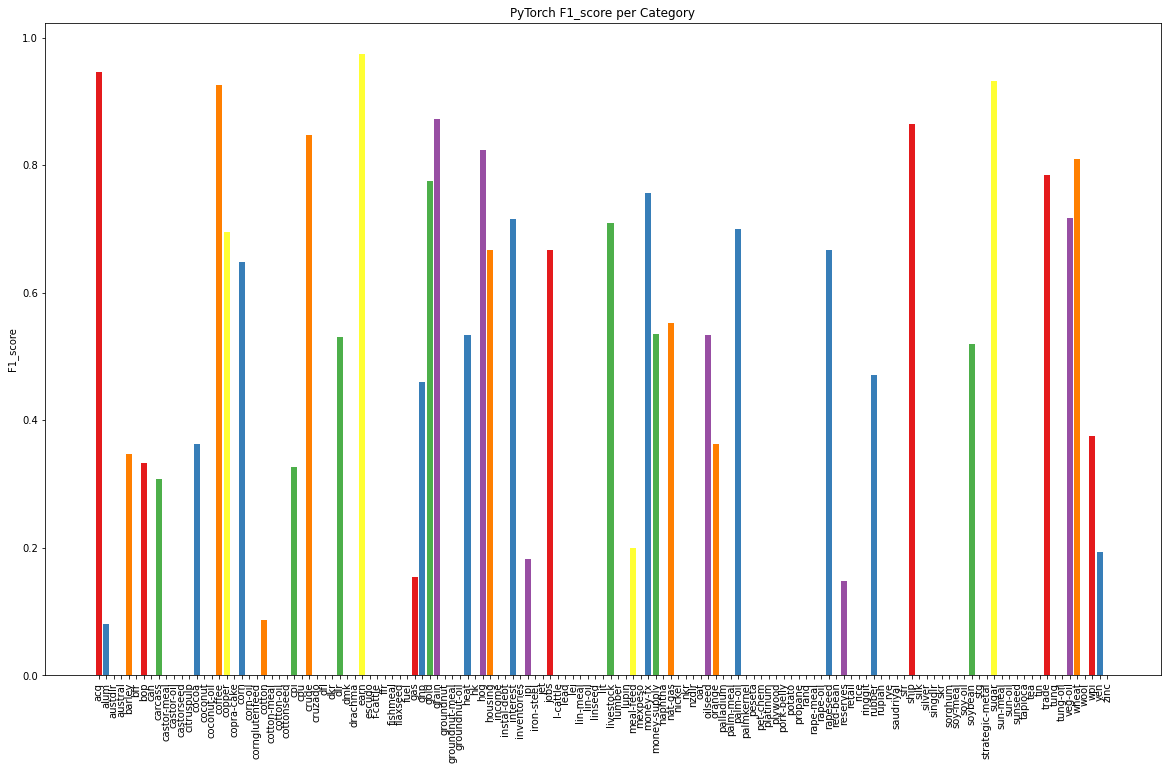

In [ ]:
ind = np.arange(len(MAIN_CATEGORIES))
palette = sns.color_palette('Set1', 6)
plt.figure(figsize=(20,12))
plt.bar(ind, ptr['F1_score'], color=palette)
plt.xticks(ind, MAIN_CATEGORIES)
plt.xticks(rotation=90, fontsize=10)
plt.title('PyTorch F1_score per Category')
plt.ylabel('F1_score')
plt.savefig(f'{main_dir}/PyTorch_F1_vs_Category.png')
plt.show()

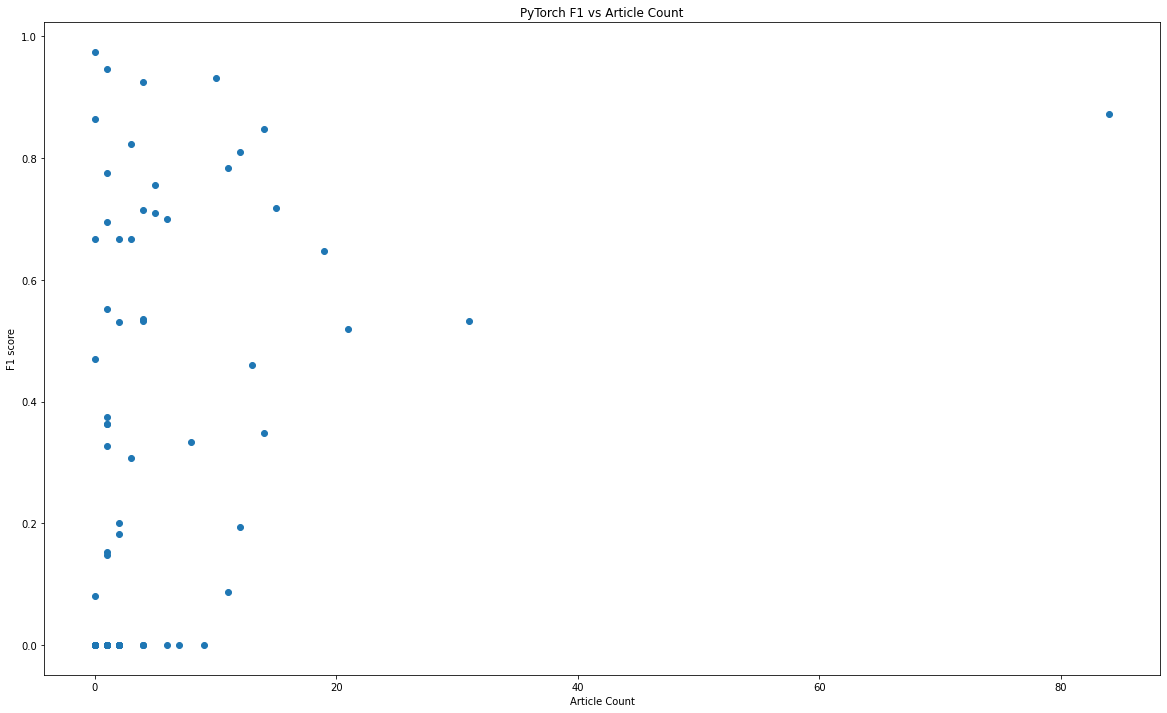

In [ ]:
plt.figure(figsize=(20,12))
plt.scatter(ptr['Article Count'], ptr['F1_score'])
plt.title('PyTorch F1 vs Article Count')
plt.xlabel('Article Count')
plt.ylabel('F1 score')
plt.savefig(f'{main_dir}/PyTorch_F1_vs_Article_Count.png')
plt.show()

## Part 3: Prediction on New Data
A few limitations on using this model on new data. \
1) It must be in SGML format \
2) All articles within the SGML file that you want predicted must have the same tag, ex. "reuters"
3) All articles within the SGML that you want predicted must have the same ID category, ex. "newid" 

In order to run the model, several earlier cells must have been run, but it is not necessary to re-run everything.  These cells have been marked with #NEEDED FOR INFERENCE.

In [ ]:
def predict_new_SGML(model, path, tag: str, id: str) -> dict:
    '''
    Takes a filepath as input, pointing to a directory with SGML files, which contain articles structured like 
    the ones in the Reuters-21578 dataset.
    Outputs a dictionary where the keys are the article IDs and the values are the categories.
    '''

    texts = {}

    for idx,file in enumerate(os.listdir(path)):
        if idx==1:
            break
        if file.endswith('.sgm'):
            f = open(path + file, 'r', encoding="ISO-8859-1")
            data = f.read()

            soup = BeautifulSoup(data, 'html.parser')
            posts = soup.findAll(f'{tag}')

            print('Number of posts in file %s: %i' % (file, len(posts)))

            for post in posts:
                post_id = post[f'{id}']

                body = str(post('body'))[7:-9] #Strip off <body> from front & </body> from the back

                if body is None or body == 'None':
                    print('body is None')
                    return 
                                
                words = body.split(' ')
                if len(words) < 10:
                    continue

                texts[post_id] = body

    print(f'Acquired {len(texts)} new texts')
    print('Shortest length: ', min([len(v) for v in texts.values()]))
    print('Greatest length: ', max([len(v) for v in texts.values()]))

    model.eval()
    predictions = {}
    for jdx, (k,text) in enumerate(texts.items()):
        tokenized = [tok.text for tok in nlp.tokenizer(text)]
        indexed = [TEXT.vocab[t] for t in tokenized]
        length = [len(indexed)]
        tensor = torch.LongTensor(indexed).to(device)
        tensor = tensor.unsqueeze(1)
        length_tensor = torch.LongTensor(length).unsqueeze(0).to(device)
        concat = torch.cat((tensor, length_tensor))
        with torch.no_grad():
            raw_prediction = model(concat).squeeze(1)
        
        rounded_raw = torch.round(raw_prediction)
        pred = rounded_raw.cpu().data.numpy().squeeze()
        
        categories = multihot_to_category(MAIN_CATEGORIES, pred)
        predictions[k] = categories

    return predictions